## Download data

In [ ]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [ ]:
|from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tomattopizza","key":"a9011039eacb97ff8387658687e51b4e"}'}

In [ ]:
! chmod 600 /content/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
%%time
! kaggle datasets download andrewmvd/liver-tumor-segmentation

100% 4.83G/4.84G [01:38<00:00, 63.9MB/s]
100% 4.84G/4.84G [01:39<00:00, 52.4MB/s]
CPU times: user 1.1 s, sys: 178 ms, total: 1.28 s
Wall time: 1min 40s


In [ ]:
%%time
zip_ref = zipfile.ZipFile('liver-tumor-segmentation.zip', 'r')
zip_ref.extractall('/content/liver-tumor-segmentation')
zip_ref.close()

CPU times: user 2min 43s, sys: 35.1 s, total: 3min 18s
Wall time: 3min 51s


In [ ]:
! rm liver-tumor-segmentation.zip

In [ ]:
%%time
! kaggle datasets download andrewmvd/liver-tumor-segmentation-part-2

100% 10.8G/10.8G [03:00<00:00, 82.2MB/s]
100% 10.8G/10.8G [03:00<00:00, 64.4MB/s]
CPU times: user 2.26 s, sys: 360 ms, total: 2.62 s
Wall time: 3min 2s


In [ ]:
%%time
zip_ref = zipfile.ZipFile('liver-tumor-segmentation-part-2.zip', 'r')
zip_ref.extractall('/content/liver-tumor-segmentation-part-2')
zip_ref.close()

CPU times: user 3min 33s, sys: 35 s, total: 4min 8s
Wall time: 4min 42s


In [ ]:
! rm liver-tumor-segmentation-part-2.zip

## Imports

In [ ]:
import pandas as pd
import os

import nibabel as nib

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

from PIL import Image

from tqdm import tqdm

## Prepare data & Look on it

In [ ]:
# Create a meta file for nii files processing
data_path = "/content"
file_list = []
for dirname, _, filenames in os.walk(data_path + '/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk(data_path + '/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
140,/content/liver-tumor-segmentation/segmentations,segmentation-0.nii
131,/content/liver-tumor-segmentation/segmentations,segmentation-1.nii
181,/content/liver-tumor-segmentation/segmentations,segmentation-10.nii
122,/content/liver-tumor-segmentation/segmentations,segmentation-100.nii
165,/content/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
247,/content/liver-tumor-segmentation-part-2/volum...,volume-95.nii
257,/content/liver-tumor-segmentation-part-2/volum...,volume-96.nii
238,/content/liver-tumor-segmentation-part-2/volum...,volume-97.nii
226,/content/liver-tumor-segmentation-part-2/volum...,volume-98.nii


In [ ]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = data_path + "/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,/content/liver-tumor-segmentation/volume_pt1,volume-0.nii,/content/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,/content/liver-tumor-segmentation/volume_pt1,volume-1.nii,/content/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,/content/liver-tumor-segmentation/volume_pt1,volume-10.nii,/content/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,/content/liver-tumor-segmentation-part-2/volum...,volume-100.nii,/content/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,/content/liver-tumor-segmentation-part-2/volum...,volume-101.nii,/content/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,/content/liver-tumor-segmentation-part-2/volum...,volume-95.nii,/content/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,/content/liver-tumor-segmentation-part-2/volum...,volume-96.nii,/content/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,/content/liver-tumor-segmentation-part-2/volum...,volume-97.nii,/content/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,/content/liver-tumor-segmentation-part-2/volum...,volume-98.nii,/content/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [ ]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [ ]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


In [ ]:
sample_ct.shape

(512, 512, 75)

In [ ]:
liver_win = (150, 30)
custom_win = (200, 60)

In [ ]:
def windowed(px_given, window):
  if window is None:
    return px_given
  px = px_given.copy()
  w, l = window
  px_min = l - w//2
  px_max = l + w//2
  px[px<px_min] = px_min
  px[px>px_max] = px_max
  return (px-px_min) / (px_max-px_min)

def plot_nii(nii, figsize=(6,4), dpi=100, window=liver_win, cmap=plt.cm.bone):
  figure(figsize=figsize, dpi=dpi)
  plt.imshow([windowed(x, window) for x in nii], cmap=cmap)


# plt.imshow([windowed(x, 150, 30) for x in sample_ct[..., 55]], cmap=plt.cm.bone)
# plot_nii(sample_ct[..., 55], figsize=(3,2))
# plot_nii(sample_mask[..., 55], figsize=(3,2), cmap=None)

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    # fig = plt.figure(figsize=(20,16), dpi=100)
    fig = plt.figure(figsize=(15,10), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    # plt.imshow(torch.tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone')
    # plt.imshow([windowed(x, 150, 30) for x in torch.tensor(array_list[0].astype(np.float32))], cmap='bone')
    plt.imshow([windowed(x, custom_win) for x in array_list[0]], cmap='bone')
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

(array([0., 1., 2.]), array([19108173,   550036,     2591]))


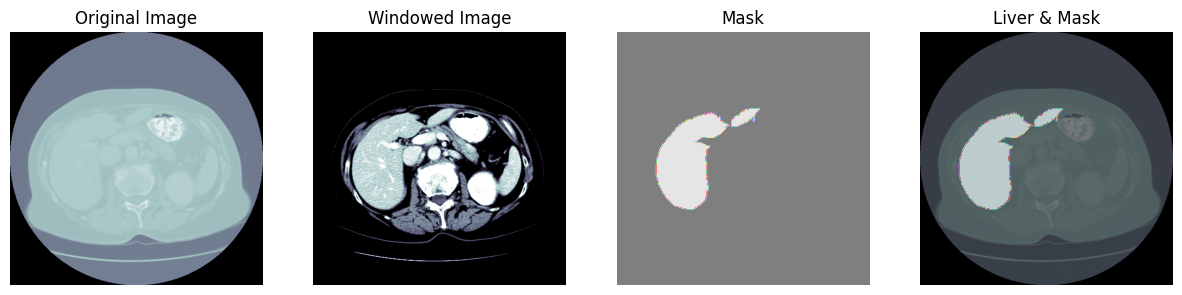

In [ ]:
dim = 55
idx = 0
sample_ct, sample_mask = get_ct(idx)

# sample_slice = torch.tensor(sample_ct[...,dim].astype(np.float32))
print(np.unique(sample_mask, return_counts=True))
plot_sample([sample_ct[..., dim],
             sample_mask[..., dim]])

(array([0., 1., 2.]), array([19108173,   550036,     2591]))


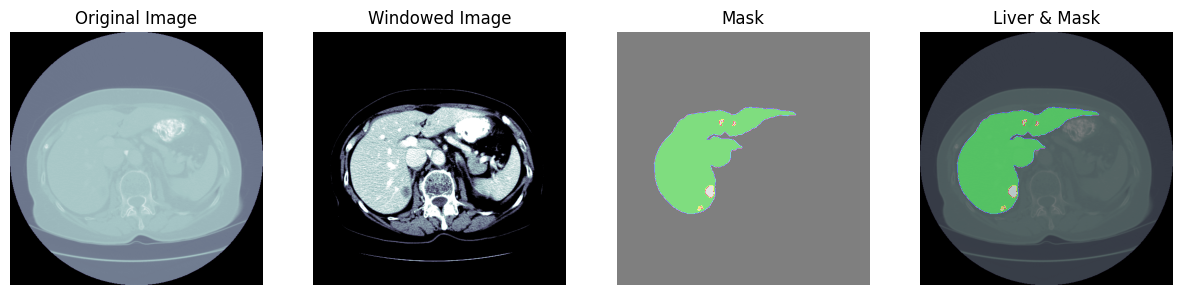

In [ ]:
dim = 58
idx = 0
sample_ct, sample_mask = get_ct(idx)

# sample_slice = torch.tensor(sample_ct[...,dim].astype(np.float32))
print(np.unique(sample_mask, return_counts=True))
plot_sample([sample_ct[..., dim],
             sample_mask[..., dim]])

## Create list of items for train and val

In [ ]:
! du -hs liver-tumor-segmentation/
! du -hs liver-tumor-segmentation-part-2/

29G	liver-tumor-segmentation/
22G	liver-tumor-segmentation-part-2/


In [ ]:
def get_ct(idx, df=df_files):
  sample_ct = read_nii(df.loc[idx,'dirname']+"/"+
                       df.loc[idx,'filename'])
  sample_mask = read_nii(df.loc[idx,'mask_dirname']+"/"+
                        df.loc[idx,'mask_filename'])
  return sample_ct, sample_mask

NameError: ignored

## Create new data images for train/eval

In [ ]:
train_data_dir = "/content/data/train"
train_data_dir_2 = "/content/data/train_2"
train_size = round(len(df_files)*1/3)

val_data_dir = "/content/data/val"
val_data_dir_2 = "/content/data/val_2"
val_size = train_size // 2

In [ ]:
def get_ct_and_mask(df, idx):
  ct = read_nii(df.loc[idx, 'dirname'] + '/' + df.loc[idx, 'filename'])
  mask = read_nii(df.loc[idx, 'mask_dirname'] + '/' + df.loc[idx, 'mask_filename'])
  file_name = str(df.loc[idx,'filename']).split('.')[0]
  dim = ct.shape[2]
  return ct, mask, file_name, dim

def save_images(df, from_idx, to_idx, dir):
  data_dir = dir + '/data'
  labels_dir = dir + '/labels'
  if not os.path.exists(data_dir):
    os.makedirs(data_dir)
  if not os.path.exists(labels_dir):
    os.makedirs(labels_dir)
  for i in tqdm(range(from_idx, to_idx)):
    curr_ct, curr_mask, curr_file_name, curr_dim = get_ct_and_mask(df, i)
    for curr_slice in range(0, curr_dim, 10):
      data = curr_ct[..., curr_slice]
      mask = curr_mask[..., curr_slice] * 255 / 2
      im_data = Image.fromarray(data).convert('L')
      im_mask = Image.fromarray(mask).convert('L')
      path_data = f"{data_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
      path_label = f"{labels_dir}/{curr_file_name}_slice_{curr_slice}.jpg"
      im_data.save(path_data)
      im_mask.save(path_label)

In [ ]:
save_images(df_files, 0, train_size, train_data_dir)
save_images(df_files, train_size, train_size + val_size, val_data_dir)

100%|██████████| 22/22 [00:53<00:00,  2.43s/it]


In [ ]:
! ls data/train/data | wc -l
! ls data/train/labels | wc -l
! ls data/val/data | wc -l
! ls data/val/labels | wc -l

2773
2773
732
732


In [ ]:
len(os.listdir(train_data_dir + '/data'))

2773

In [ ]:
! mkdir drive/MyDrive/Colab\ Notebooks/liver_tumor_data

In [ ]:
# Save it to my Google Drive
! cp -r data/ drive/MyDrive/Colab\ Notebooks/liver_tumor_data

## Copy created datasets

In [ ]:
%%time
! cp -r drive/MyDrive/Colab\ Notebooks/liver_tumor_data/data .

CPU times: user 1.48 s, sys: 189 ms, total: 1.67 s
Wall time: 3min 2s


## Describe my custom dataset

In [ ]:
class DatasetLiverCT(Dataset):
  def __init__(self, data_dir, mode='train', transform = None, 
               liver_thr = 40, tumor_thr = 230) -> None:
    self.data_dir = data_dir
    self.data_path = data_dir + '/data/'
    self.labels_path = data_dir + '/labels/'
    self.mode = mode
    self.transform = transform
    self.tumor_thr = tumor_thr
    self.liver_thr = liver_thr
  
  def __len__(self):
    return len(os.listdir(self.data_dir + '/data'))
  
  def __getitem__(self, idx):
    img_path = self.data_path + os.listdir(self.data_path)[idx]
    img = Image.open(img_path)
    if self.transform is not None:
      img = self.transform(img)
    img = np.array(img)
    if self.mode == 'train':
      label_path = self.labels_path + img_path.split('/')[-1]
      label = Image.open(label_path).convert("L")
      if self.transform is not None:
        label = self.transform(label)

      label = np.array(label) * 255
      label[label < self.liver_thr] = 0
      label[(label >= self.liver_thr) & (label < self.tumor_thr)] = 1
      label[label >= self.tumor_thr] = 2

      # unique, counts = np.unique(label, return_counts=True)
      # print( np.array((unique, counts)).T)

      return img.astype('float32'), label
    else:
      return img.astype('float32')
  
  def get_file_name(self, idx):
    return os.listdir(self.data_path)[idx].split('/')[0]

In [ ]:
# IMAGE_SIZE = 256
IMAGE_SIZE = 128
data_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    # transforms.ColorJitter(),
    # transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.Resize(128),
    transforms.ToTensor()
])

## Create sanity-check test dataset

In [ ]:
! rm -r test_data/
! mkdir -p test_data/train/data
! mkdir -p test_data/train/labels

rm: cannot remove 'test_data/': No such file or directory


In [ ]:
import shutil

drive_path = "/content/drive/MyDrive/Colab Notebooks/liver_tumor_data/data/train/"
images_for_test = [
                   "volume-100_slice_610.jpg",
                   "volume-0_slice_60.jpg",
                   "volume-0_slice_10.jpg",
                   "volume-108_slice_540.jpg",
                   "volume-109_slice_560.jpg",
]

test_dataset_dir = "/content/test_data/train"
data_dir = test_dataset_dir + '/data/'
labels_dir = test_dataset_dir + '/labels/'
# if not os.path.exists(data_dir):
#   os.makedirs(data_dir)

for filename in images_for_test:
  src = drive_path + 'data/' + filename
  shutil.copyfile(src, data_dir + filename)
  src = drive_path + 'labels/' + filename
  shutil.copyfile(src, labels_dir + filename)

In [ ]:
train_ds_test = DatasetLiverCT('test_data/train', transform=data_transform)
train_dl_test = DataLoader(train_ds_test, batch_size=32)
val_dl_test = DataLoader(train_ds_test, batch_size=32)

## Create test/val datasets and dataloaders

In [ ]:
train_data_dir = "/content/data/train"
val_data_dir = "/content/data/val"

In [ ]:
train_ds = DatasetLiverCT(train_data_dir, transform=data_transform)
val_ds = DatasetLiverCT(val_data_dir, transform=data_transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, num_workers=0)

In [ ]:
unique, counts = np.unique(train_ds[210][1], return_counts=True)
print( np.array((unique, counts)).T)

[[0.0000e+00 1.5207e+04]
 [1.0000e+00 1.1320e+03]
 [2.0000e+00 4.5000e+01]]


Let's check classes representation in our datasets

In [ ]:
def cnt_classes_in_dataset(ds):
  cnt_all = 0
  cnt_1 = 0
  cnt_2 = 0
  for i in range(len(ds)):
    cnt_all += 1
    found_1_and_2 = False
    _, label = ds[i]
    if 1 in label:
      cnt_1 += 1
    if 2 in label:
      cnt_2 += 1
  print('All:', cnt_all)
  print('Class 1:', cnt_1, cnt_1/cnt_all)
  print('Class 2:', cnt_2, cnt_2/cnt_all)

In [ ]:
cnt_classes_in_dataset(train_ds)

All: 2773
Class 1: 792 0.285611251352326
Class 2: 313 0.11287414352686621


In [ ]:
cnt_classes_in_dataset(val_ds)

All: 732
Class 1: 303 0.4139344262295082
Class 2: 98 0.13387978142076504


Maybe need to upsample Class 1 and 2 in train

In [ ]:
samples, labels = iter(train_dl).next()

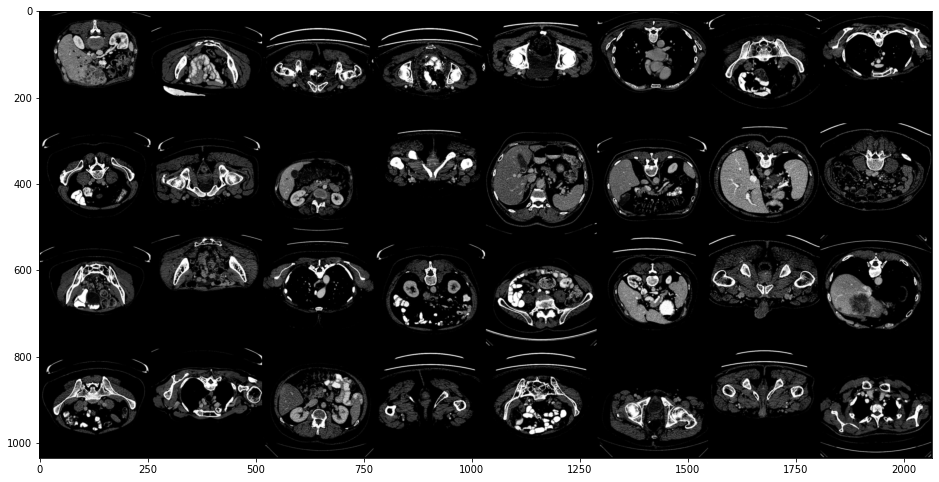

In [ ]:
plt.figure(figsize=(16,24)) 
grid_imgs = torchvision.utils.make_grid(samples) 
np_grid_imgs = grid_imgs.numpy() 
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

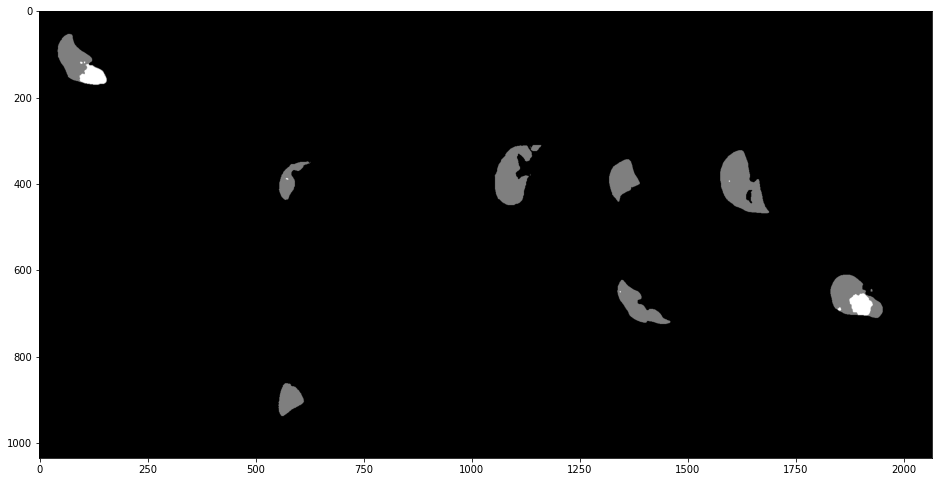

In [ ]:
plt.figure(figsize=(16,24)) 
grid_imgs = torchvision.utils.make_grid(labels/2) 
np_grid_imgs = grid_imgs.numpy() 
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

## Build segmentation model

In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF 

class UNET(nn.Module):
    
    def __init__(self, in_channels=3, classes=1, base_model = None):
        super(UNET, self).__init__()
        # self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        if base_model is None:
          self.layers = [in_channels, 32, 64, 128]
          self.double_conv_downs = nn.ModuleList(
              [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        else:
          self.layers = []
          self.base_layers = list(base_model.children())
          double_conv_downs_list = []

          double_conv_downs_list.append(nn.Sequential(*self.base_layers[:3]))
          self.layers.append(double_conv_downs_list[-1][0].out_channels)

          double_conv_downs_list.append(nn.Sequential(*self.base_layers[3:5]))
          self.layers.append(self.base_layers[3:5][-1][-1].conv2.out_channels)

          double_conv_downs_list.append(nn.Sequential(self.base_layers[5]))
          self.layers.append(self.base_layers[5][-1].conv2.out_channels)

          double_conv_downs_list.append(nn.Sequential(self.base_layers[6]))
          self.layers.append(self.base_layers[6][-1].conv2.out_channels)

          double_conv_downs_list.append(nn.Sequential(self.base_layers[7]))
          self.layers.append(self.base_layers[7][-1].conv2.out_channels)

          print(double_conv_downs_list)
          self.double_conv_downs = nn.ModuleList(double_conv_downs_list)
        
        print(self.layers)

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
        
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # self.final_conv = nn.Conv2d(64, classes, kernel_size=1)
        self.final_conv = nn.Conv2d(self.layers[1], classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x

In [ ]:
base_model = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = UNET(in_channels=1, classes=3, base_model=base_model)

[Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
), Sequential(
  (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
l = nn.Conv2d(3, 64, 3)

In [ ]:
l

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))

In [ ]:
l.out_channels

64

In [ ]:
nn.Sequential(*bl_1[:3])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [ ]:
t = bl_1[3:5][-1][-1]

In [ ]:
t

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
t.conv2

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

## Train

In [ ]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
import pdb
# from utils import *
# from model import UNET

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

MODEL_PATH = 'YOUR-MODEL-PATH'
LOAD_MODEL = False
ROOT_DIR = '../datasets/cityscapes'
IMG_HEIGHT = 110  
IMG_WIDTH = 220  
BATCH_SIZE = 16 
LEARNING_RATE = 0.0005
# LEARNING_RATE = 0.00005
EPOCHS = 200

def train_val_function(data_train, data_val, model, optimizer, loss_fn, device):
    print('Entering into train/val function')
    loss_values = []
    model.train()
    data = tqdm(data_train)
    for index, batch in enumerate(data): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)

        # print(preds.shape, y.shape)
        # pdb.set_trace()
        # loss = loss_fn(preds, y)
        loss = loss_fn(
            preds, 
            torch.squeeze(y, 1).type(torch.LongTensor).to(device)
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    data = tqdm(data_val)
    with torch.no_grad():
      for index, batch in enumerate(data): 
          X, y = batch
          X, y = X.to(device), y.to(device)
          preds = model(X)

          # print(preds.shape, y.shape)
          # pdb.set_trace()
          # loss = loss_fn(preds, y)
          loss_val = loss_fn(
              preds, 
              torch.squeeze(y, 1).type(torch.LongTensor).to(device)
          )
          # optimizer.zero_grad()
          # loss_val.backward()
          # optimizer.step()

    return loss.item(), loss_val.item()
        

def main():
    global epoch
    epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
              # epoch is set to the last value + 1. 
    LOSS_VALS = [] # Defining a list to store loss values after every epoch
    
    # transform = transforms.Compose([
    #     transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
    # ]) 

    # train_set = get_cityscapes_data(
    #     split='train',
    #     mode='fine',
    #     relabelled=True,
    #     root_dir=ROOT_DIR,
    #     transforms=transform,
    #     batch_size=BATCH_SIZE,
    # )

    # train_set = train_dl

    # train_set = train_dl_test
    # val_set = val_dl_test
    
    train_set = train_dl
    val_set = val_dl

    print('Data Loaded Successfully!')

    # Defining the model, optimizer and loss function
    unet = UNET(in_channels=1, classes=3).to(DEVICE).train()
    optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
    # loss_function = nn.CrossEntropyLoss(ignore_index=255)
    # loss_function = nn.CrossEntropyLoss()
    loss_function = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 10, 100]).to(DEVICE))

    # Loading a previous stored model from MODEL_PATH variable
    if LOAD_MODEL == True:
        checkpoint = torch.load(MODEL_PATH)
        unet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        epoch = checkpoint['epoch']+1
        LOSS_VALS = checkpoint['loss_values']
        print("Model successfully loaded!")    

    #Training the model for every epoch. 
    for e in range(epoch, EPOCHS):
        print(f'Epoch: {e}')
        loss_train, loss_val = train_val_function(
            train_set, val_set, unet, 
            optimizer, loss_function, DEVICE
        )
        LOSS_VALS.append([loss_train, loss_val]) 
        # torch.save({
        #     'model_state_dict': unet.state_dict(),
        #     'optim_state_dict': optimizer.state_dict(),
        #     'epoch': e,
        #     'loss_values': LOSS_VALS
        # }, MODEL_PATH)
        print('Train loss:', loss_train, ', Val loss:', loss_val)
        print("Epoch completed and model successfully saved!")
      # print(LOSS_VALS)
    return unet

Running on the GPU


In [ ]:
model = main()

Running on the GPU
Data Loaded Successfully!
Epoch: 0
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 1.1094002723693848 , Val loss: 1.1068437099456787
Epoch completed and model successfully saved!
Epoch: 1
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Train loss: 0.8753784894943237 , Val loss: 1.1007765531539917
Epoch completed and model successfully saved!
Epoch: 2
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.6602776646614075 , Val loss: 1.093860149383545
Epoch completed and model successfully saved!
Epoch: 3
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Train loss: 0.596641480922699 , Val loss: 1.0873498916625977
Epoch completed and model successfully saved!
Epoch: 4
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.4906049072742462 , Val loss: 1.0747876167297363
Epoch completed and model successfully saved!
Epoch: 5
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.4197043180465698 , Val loss: 1.058113932609558
Epoch completed and model successfully saved!
Epoch: 6
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Train loss: 0.3921996057033539 , Val loss: 1.0388301610946655
Epoch completed and model successfully saved!
Epoch: 7
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.3488801419734955 , Val loss: 1.0154868364334106
Epoch completed and model successfully saved!
Epoch: 8
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Train loss: 0.34165728092193604 , Val loss: 0.9924955368041992
Epoch completed and model successfully saved!
Epoch: 9
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.306753545999527 , Val loss: 0.9730213284492493
Epoch completed and model successfully saved!
Epoch: 10
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 0.3015402555465698 , Val loss: 0.9499996900558472
Epoch completed and model successfully saved!
Epoch: 11
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.2721189856529236 , Val loss: 0.9248164892196655
Epoch completed and model successfully saved!
Epoch: 12
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.27368292212486267 , Val loss: 0.9008421301841736
Epoch completed and model successfully saved!
Epoch: 13
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.24376001954078674 , Val loss: 0.8820540308952332
Epoch completed and model successfully saved!
Epoch: 14
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Train loss: 0.2414012998342514 , Val loss: 0.8565974235534668
Epoch completed and model successfully saved!
Epoch: 15
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.21921485662460327 , Val loss: 0.8306831121444702
Epoch completed and model successfully saved!
Epoch: 16
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.21538764238357544 , Val loss: 0.8202623128890991
Epoch completed and model successfully saved!
Epoch: 17
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.19582954049110413 , Val loss: 0.8180043697357178
Epoch completed and model successfully saved!
Epoch: 18
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Train loss: 0.18906305730342865 , Val loss: 0.8003931641578674
Epoch completed and model successfully saved!
Epoch: 19
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Train loss: 0.1731928437948227 , Val loss: 0.780089259147644
Epoch completed and model successfully saved!
Epoch: 20
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.16855616867542267 , Val loss: 0.8009998202323914
Epoch completed and model successfully saved!
Epoch: 21
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Train loss: 0.15201620757579803 , Val loss: 0.8319645524024963
Epoch completed and model successfully saved!
Epoch: 22
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.14580528438091278 , Val loss: 0.8250187635421753
Epoch completed and model successfully saved!
Epoch: 23
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Train loss: 0.13061118125915527 , Val loss: 0.8220213651657104
Epoch completed and model successfully saved!
Epoch: 24
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Train loss: 0.1244884729385376 , Val loss: 0.8540717363357544
Epoch completed and model successfully saved!
Epoch: 25
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.1159161776304245 , Val loss: 0.8510058522224426
Epoch completed and model successfully saved!
Epoch: 26
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Train loss: 0.10782533138990402 , Val loss: 0.844562292098999
Epoch completed and model successfully saved!
Epoch: 27
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.100106380879879 , Val loss: 0.8513058423995972
Epoch completed and model successfully saved!
Epoch: 28
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Train loss: 0.09400205314159393 , Val loss: 0.8717861771583557
Epoch completed and model successfully saved!
Epoch: 29
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Train loss: 0.08767063915729523 , Val loss: 0.8177742958068848
Epoch completed and model successfully saved!
Epoch: 30
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Train loss: 0.09632553905248642 , Val loss: 1.3499361276626587
Epoch completed and model successfully saved!
Epoch: 31
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Train loss: 0.15704303979873657 , Val loss: 0.9109955430030823
Epoch completed and model successfully saved!
Epoch: 32
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.09893373399972916 , Val loss: 0.5357515811920166
Epoch completed and model successfully saved!
Epoch: 33
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.13998474180698395 , Val loss: 0.6131308674812317
Epoch completed and model successfully saved!
Epoch: 34
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Train loss: 0.09153599292039871 , Val loss: 0.7339349389076233
Epoch completed and model successfully saved!
Epoch: 35
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Train loss: 0.11497314274311066 , Val loss: 0.6841959953308105
Epoch completed and model successfully saved!
Epoch: 36
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Train loss: 0.10669407993555069 , Val loss: 0.5081392526626587
Epoch completed and model successfully saved!
Epoch: 37
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.0875355526804924 , Val loss: 0.3844524025917053
Epoch completed and model successfully saved!
Epoch: 38
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.09246377646923065 , Val loss: 0.36776769161224365
Epoch completed and model successfully saved!
Epoch: 39
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Train loss: 0.09023696929216385 , Val loss: 0.38761645555496216
Epoch completed and model successfully saved!
Epoch: 40
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.0792696624994278 , Val loss: 0.3401239812374115
Epoch completed and model successfully saved!
Epoch: 41
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Train loss: 0.08013889193534851 , Val loss: 0.23736712336540222
Epoch completed and model successfully saved!
Epoch: 42
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Train loss: 0.07847721129655838 , Val loss: 0.1920354962348938
Epoch completed and model successfully saved!
Epoch: 43
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.07864193618297577 , Val loss: 0.2980480194091797
Epoch completed and model successfully saved!
Epoch: 44
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.06608066707849503 , Val loss: 0.4246053993701935
Epoch completed and model successfully saved!
Epoch: 45
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.06593336910009384 , Val loss: 0.43407654762268066
Epoch completed and model successfully saved!
Epoch: 46
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.06632264703512192 , Val loss: 0.3736104965209961
Epoch completed and model successfully saved!
Epoch: 47
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.06524024158716202 , Val loss: 0.32744356989860535
Epoch completed and model successfully saved!
Epoch: 48
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.05960638448596001 , Val loss: 0.29393717646598816
Epoch completed and model successfully saved!
Epoch: 49
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.05754166096448898 , Val loss: 0.2594844698905945
Epoch completed and model successfully saved!
Epoch: 50
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Train loss: 0.05813169851899147 , Val loss: 0.23786093294620514
Epoch completed and model successfully saved!
Epoch: 51
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.05585780739784241 , Val loss: 0.24286140501499176
Epoch completed and model successfully saved!
Epoch: 52
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.05303104594349861 , Val loss: 0.2838670015335083
Epoch completed and model successfully saved!
Epoch: 53
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Train loss: 0.05155336484313011 , Val loss: 0.3330266773700714
Epoch completed and model successfully saved!
Epoch: 54
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.05060792714357376 , Val loss: 0.3110041618347168
Epoch completed and model successfully saved!
Epoch: 55
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Train loss: 0.04875113070011139 , Val loss: 0.2396143227815628
Epoch completed and model successfully saved!
Epoch: 56
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.046615708619356155 , Val loss: 0.2156798243522644
Epoch completed and model successfully saved!
Epoch: 57
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.04562433436512947 , Val loss: 0.22009412944316864
Epoch completed and model successfully saved!
Epoch: 58
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Train loss: 0.04499461501836777 , Val loss: 0.2053571343421936
Epoch completed and model successfully saved!
Epoch: 59
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.04390288516879082 , Val loss: 0.19761095941066742
Epoch completed and model successfully saved!
Epoch: 60
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.042196132242679596 , Val loss: 0.190728098154068
Epoch completed and model successfully saved!
Epoch: 61
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.04114542901515961 , Val loss: 0.16746902465820312
Epoch completed and model successfully saved!
Epoch: 62
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Train loss: 0.040209632366895676 , Val loss: 0.1597660779953003
Epoch completed and model successfully saved!
Epoch: 63
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.039498936384916306 , Val loss: 0.14477965235710144
Epoch completed and model successfully saved!
Epoch: 64
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.0374859981238842 , Val loss: 0.11211421340703964
Epoch completed and model successfully saved!
Epoch: 65
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Train loss: 0.03747788071632385 , Val loss: 0.18043945729732513
Epoch completed and model successfully saved!
Epoch: 66
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Train loss: 0.03907665237784386 , Val loss: 0.07922104001045227
Epoch completed and model successfully saved!
Epoch: 67
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Train loss: 0.03899006545543671 , Val loss: 0.28057369589805603
Epoch completed and model successfully saved!
Epoch: 68
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Train loss: 0.04821791127324104 , Val loss: 0.13795220851898193
Epoch completed and model successfully saved!
Epoch: 69
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Train loss: 0.036424946039915085 , Val loss: 0.04748368635773659
Epoch completed and model successfully saved!
Epoch: 70
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Train loss: 0.06157446652650833 , Val loss: 0.883427083492279
Epoch completed and model successfully saved!
Epoch: 71
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.08944252133369446 , Val loss: 0.6548486351966858
Epoch completed and model successfully saved!
Epoch: 72
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Train loss: 0.08693995326757431 , Val loss: 0.17723341286182404
Epoch completed and model successfully saved!
Epoch: 73
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Train loss: 0.056620221585035324 , Val loss: 0.08277057111263275
Epoch completed and model successfully saved!
Epoch: 74
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.09408928453922272 , Val loss: 0.05739474296569824
Epoch completed and model successfully saved!
Epoch: 75
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 0.05039161816239357 , Val loss: 0.07589013874530792
Epoch completed and model successfully saved!
Epoch: 76
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train loss: 0.05590655282139778 , Val loss: 0.13485929369926453
Epoch completed and model successfully saved!
Epoch: 77
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 0.0601905956864357 , Val loss: 0.33614596724510193
Epoch completed and model successfully saved!
Epoch: 78
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Train loss: 0.052207786589860916 , Val loss: 0.9071394205093384
Epoch completed and model successfully saved!
Epoch: 79
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.05056387186050415 , Val loss: 1.332674503326416
Epoch completed and model successfully saved!
Epoch: 80
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.04766412079334259 , Val loss: 1.11941397190094
Epoch completed and model successfully saved!
Epoch: 81
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.046248868107795715 , Val loss: 0.6529752016067505
Epoch completed and model successfully saved!
Epoch: 82
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.047448981553316116 , Val loss: 0.38427242636680603
Epoch completed and model successfully saved!
Epoch: 83
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.043411608785390854 , Val loss: 0.28011956810951233
Epoch completed and model successfully saved!
Epoch: 84
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.0410110242664814 , Val loss: 0.22076986730098724
Epoch completed and model successfully saved!
Epoch: 85
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.04262761026620865 , Val loss: 0.15683753788471222
Epoch completed and model successfully saved!
Epoch: 86
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.03871404752135277 , Val loss: 0.12135124206542969
Epoch completed and model successfully saved!
Epoch: 87
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.03886869177222252 , Val loss: 0.08115499466657639
Epoch completed and model successfully saved!
Epoch: 88
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train loss: 0.0377190001308918 , Val loss: 0.05085065960884094
Epoch completed and model successfully saved!
Epoch: 89
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Train loss: 0.035897158086299896 , Val loss: 0.04226158559322357
Epoch completed and model successfully saved!
Epoch: 90
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.035920366644859314 , Val loss: 0.0355132631957531
Epoch completed and model successfully saved!
Epoch: 91
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 0.0338500440120697 , Val loss: 0.03537673130631447
Epoch completed and model successfully saved!
Epoch: 92
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.03412375971674919 , Val loss: 0.035794518887996674
Epoch completed and model successfully saved!
Epoch: 93
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Train loss: 0.032491303980350494 , Val loss: 0.042155515402555466
Epoch completed and model successfully saved!
Epoch: 94
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.032051924616098404 , Val loss: 0.03396119177341461
Epoch completed and model successfully saved!
Epoch: 95
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.030593344941735268 , Val loss: 0.03761362284421921
Epoch completed and model successfully saved!
Epoch: 96
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.030016383156180382 , Val loss: 0.040439754724502563
Epoch completed and model successfully saved!
Epoch: 97
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train loss: 0.02909918688237667 , Val loss: 0.03814907744526863
Epoch completed and model successfully saved!
Epoch: 98
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.028476927429437637 , Val loss: 0.048890870064496994
Epoch completed and model successfully saved!
Epoch: 99
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.027828142046928406 , Val loss: 0.05592235550284386
Epoch completed and model successfully saved!
Epoch: 100
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train loss: 0.02710006758570671 , Val loss: 0.0457623116672039
Epoch completed and model successfully saved!
Epoch: 101
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.02655334398150444 , Val loss: 0.04708288982510567
Epoch completed and model successfully saved!
Epoch: 102
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Train loss: 0.02602643147110939 , Val loss: 0.056571491062641144
Epoch completed and model successfully saved!
Epoch: 103
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.025221729651093483 , Val loss: 0.04616371914744377
Epoch completed and model successfully saved!
Epoch: 104
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.024901699274778366 , Val loss: 0.03917180374264717
Epoch completed and model successfully saved!
Epoch: 105
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.024347955361008644 , Val loss: 0.0499722994863987
Epoch completed and model successfully saved!
Epoch: 106
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.024463186040520668 , Val loss: 0.03964767977595329
Epoch completed and model successfully saved!
Epoch: 107
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train loss: 0.023056792095303535 , Val loss: 0.03463057056069374
Epoch completed and model successfully saved!
Epoch: 108
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Train loss: 0.023338573053479195 , Val loss: 0.060337524861097336
Epoch completed and model successfully saved!
Epoch: 109
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.024855589494109154 , Val loss: 0.035122595727443695
Epoch completed and model successfully saved!
Epoch: 110
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Train loss: 0.022282857447862625 , Val loss: 0.03480067476630211
Epoch completed and model successfully saved!
Epoch: 111
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Train loss: 0.02141941338777542 , Val loss: 0.04741516336798668
Epoch completed and model successfully saved!
Epoch: 112
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.022080739960074425 , Val loss: 0.02983752079308033
Epoch completed and model successfully saved!
Epoch: 113
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train loss: 0.021861165761947632 , Val loss: 0.06029629707336426
Epoch completed and model successfully saved!
Epoch: 114
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Train loss: 0.024477768689393997 , Val loss: 0.02932191640138626
Epoch completed and model successfully saved!
Epoch: 115
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.01987992413341999 , Val loss: 0.025997303426265717
Epoch completed and model successfully saved!
Epoch: 116
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.020569253712892532 , Val loss: 0.07192183285951614
Epoch completed and model successfully saved!
Epoch: 117
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.026603396981954575 , Val loss: 0.029673218727111816
Epoch completed and model successfully saved!
Epoch: 118
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.01900063268840313 , Val loss: 0.04174794256687164
Epoch completed and model successfully saved!
Epoch: 119
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.03497795760631561 , Val loss: 1.0596598386764526
Epoch completed and model successfully saved!
Epoch: 120
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.09106840193271637 , Val loss: 0.2969515919685364
Epoch completed and model successfully saved!
Epoch: 121
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.06667537242174149 , Val loss: 0.13110807538032532
Epoch completed and model successfully saved!
Epoch: 122
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.07456021755933762 , Val loss: 0.08293181657791138
Epoch completed and model successfully saved!
Epoch: 123
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.07281385362148285 , Val loss: 0.0733100026845932
Epoch completed and model successfully saved!
Epoch: 124
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Train loss: 0.03862776607275009 , Val loss: 0.15026628971099854
Epoch completed and model successfully saved!
Epoch: 125
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.05405867099761963 , Val loss: 0.25576117634773254
Epoch completed and model successfully saved!
Epoch: 126
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Train loss: 0.04714370146393776 , Val loss: 0.28178316354751587
Epoch completed and model successfully saved!
Epoch: 127
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Train loss: 0.05246146395802498 , Val loss: 0.5686802268028259
Epoch completed and model successfully saved!
Epoch: 128
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.057571399956941605 , Val loss: 0.9268444776535034
Epoch completed and model successfully saved!
Epoch: 129
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.053400006145238876 , Val loss: 1.083587646484375
Epoch completed and model successfully saved!
Epoch: 130
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.04952355474233627 , Val loss: 1.0327200889587402
Epoch completed and model successfully saved!
Epoch: 131
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.04501781985163689 , Val loss: 1.2998721599578857
Epoch completed and model successfully saved!
Epoch: 132
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.043088458478450775 , Val loss: 1.4245085716247559
Epoch completed and model successfully saved!
Epoch: 133
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.04243582859635353 , Val loss: 1.1782946586608887
Epoch completed and model successfully saved!
Epoch: 134
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.0401582233607769 , Val loss: 1.1785743236541748
Epoch completed and model successfully saved!
Epoch: 135
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.039913538843393326 , Val loss: 1.3434927463531494
Epoch completed and model successfully saved!
Epoch: 136
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.037034884095191956 , Val loss: 1.2037396430969238
Epoch completed and model successfully saved!
Epoch: 137
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.03550570085644722 , Val loss: 0.5955117344856262
Epoch completed and model successfully saved!
Epoch: 138
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.03285982832312584 , Val loss: 0.2462218552827835
Epoch completed and model successfully saved!
Epoch: 139
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.03253061696887016 , Val loss: 0.17249655723571777
Epoch completed and model successfully saved!
Epoch: 140
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.0314268097281456 , Val loss: 0.19453895092010498
Epoch completed and model successfully saved!
Epoch: 141
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.03026381880044937 , Val loss: 0.15319208800792694
Epoch completed and model successfully saved!
Epoch: 142
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train loss: 0.028698809444904327 , Val loss: 0.09879890829324722
Epoch completed and model successfully saved!
Epoch: 143
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Train loss: 0.028308356180787086 , Val loss: 0.07973328232765198
Epoch completed and model successfully saved!
Epoch: 144
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.027038583531975746 , Val loss: 0.0795922577381134
Epoch completed and model successfully saved!
Epoch: 145
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.026147326454520226 , Val loss: 0.05530549958348274
Epoch completed and model successfully saved!
Epoch: 146
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.025379683822393417 , Val loss: 0.040334220975637436
Epoch completed and model successfully saved!
Epoch: 147
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.025180896744132042 , Val loss: 0.04709379002451897
Epoch completed and model successfully saved!
Epoch: 148
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.023702513426542282 , Val loss: 0.05712851881980896
Epoch completed and model successfully saved!
Epoch: 149
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.023665059357881546 , Val loss: 0.029945392161607742
Epoch completed and model successfully saved!
Epoch: 150
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.022698286920785904 , Val loss: 0.027604658156633377
Epoch completed and model successfully saved!
Epoch: 151
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.02157401666045189 , Val loss: 0.03766876831650734
Epoch completed and model successfully saved!
Epoch: 152
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Train loss: 0.021542243659496307 , Val loss: 0.022813109681010246
Epoch completed and model successfully saved!
Epoch: 153
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.020692050457000732 , Val loss: 0.023527197539806366
Epoch completed and model successfully saved!
Epoch: 154
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.019443469122052193 , Val loss: 0.03538002818822861
Epoch completed and model successfully saved!
Epoch: 155
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.020288147032260895 , Val loss: 0.02634100429713726
Epoch completed and model successfully saved!
Epoch: 156
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.022167304530739784 , Val loss: 0.023381175473332405
Epoch completed and model successfully saved!
Epoch: 157
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.018518222495913506 , Val loss: 0.058616798371076584
Epoch completed and model successfully saved!
Epoch: 158
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.026723012328147888 , Val loss: 0.09652337431907654
Epoch completed and model successfully saved!
Epoch: 159
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.04340365156531334 , Val loss: 0.1124640703201294
Epoch completed and model successfully saved!
Epoch: 160
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.04377451911568642 , Val loss: 0.0419229194521904
Epoch completed and model successfully saved!
Epoch: 161
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.03071274422109127 , Val loss: 0.04023845121264458
Epoch completed and model successfully saved!
Epoch: 162
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Train loss: 0.03715416043996811 , Val loss: 0.043535299599170685
Epoch completed and model successfully saved!
Epoch: 163
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Train loss: 0.024645591154694557 , Val loss: 0.04984952509403229
Epoch completed and model successfully saved!
Epoch: 164
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.02817883901298046 , Val loss: 0.04294503480195999
Epoch completed and model successfully saved!
Epoch: 165
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.0280651543289423 , Val loss: 0.039442699402570724
Epoch completed and model successfully saved!
Epoch: 166
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.026610495522618294 , Val loss: 0.026738204061985016
Epoch completed and model successfully saved!
Epoch: 167
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.024323085322976112 , Val loss: 0.02659916877746582
Epoch completed and model successfully saved!
Epoch: 168
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.024478325620293617 , Val loss: 0.024823086336255074
Epoch completed and model successfully saved!
Epoch: 169
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Train loss: 0.01992330700159073 , Val loss: 0.026047173887491226
Epoch completed and model successfully saved!
Epoch: 170
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.021743984892964363 , Val loss: 0.025720443576574326
Epoch completed and model successfully saved!
Epoch: 171
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Train loss: 0.02202293835580349 , Val loss: 0.02407408319413662
Epoch completed and model successfully saved!
Epoch: 172
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.020528104156255722 , Val loss: 0.023126743733882904
Epoch completed and model successfully saved!
Epoch: 173
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Train loss: 0.02062598243355751 , Val loss: 0.021555233746767044
Epoch completed and model successfully saved!
Epoch: 174
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train loss: 0.018892401829361916 , Val loss: 0.026903970167040825
Epoch completed and model successfully saved!
Epoch: 175
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Train loss: 0.018302053213119507 , Val loss: 0.025058507919311523
Epoch completed and model successfully saved!
Epoch: 176
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.01779632270336151 , Val loss: 0.01949106901884079
Epoch completed and model successfully saved!
Epoch: 177
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.017572585493326187 , Val loss: 0.0203312449157238
Epoch completed and model successfully saved!
Epoch: 178
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.017251305282115936 , Val loss: 0.027957936748862267
Epoch completed and model successfully saved!
Epoch: 179
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.016804005950689316 , Val loss: 0.026338674128055573
Epoch completed and model successfully saved!
Epoch: 180
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.01611487567424774 , Val loss: 0.018233545124530792
Epoch completed and model successfully saved!
Epoch: 181
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.015034638345241547 , Val loss: 0.01763318106532097
Epoch completed and model successfully saved!
Epoch: 182
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Train loss: 0.015077214688062668 , Val loss: 0.0188275333493948
Epoch completed and model successfully saved!
Epoch: 183
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Train loss: 0.01465345174074173 , Val loss: 0.021800821647047997
Epoch completed and model successfully saved!
Epoch: 184
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Train loss: 0.015010909177362919 , Val loss: 0.01796669326722622
Epoch completed and model successfully saved!
Epoch: 185
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Train loss: 0.01387613546103239 , Val loss: 0.016947459429502487
Epoch completed and model successfully saved!
Epoch: 186
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.013603972271084785 , Val loss: 0.019968323409557343
Epoch completed and model successfully saved!
Epoch: 187
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Train loss: 0.01306829508394003 , Val loss: 0.026335325092077255
Epoch completed and model successfully saved!
Epoch: 188
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Train loss: 0.013254859484732151 , Val loss: 0.019312195479869843
Epoch completed and model successfully saved!
Epoch: 189
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Train loss: 0.012909116223454475 , Val loss: 0.01669563353061676
Epoch completed and model successfully saved!
Epoch: 190
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Train loss: 0.012550794519484043 , Val loss: 0.017899902537465096
Epoch completed and model successfully saved!
Epoch: 191
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.01213714387267828 , Val loss: 0.015865975990891457
Epoch completed and model successfully saved!
Epoch: 192
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Train loss: 0.011720984242856503 , Val loss: 0.014302670024335384
Epoch completed and model successfully saved!
Epoch: 193
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Train loss: 0.011688373051583767 , Val loss: 0.014826539903879166
Epoch completed and model successfully saved!
Epoch: 194
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.011411940678954124 , Val loss: 0.01630105823278427
Epoch completed and model successfully saved!
Epoch: 195
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Train loss: 0.011263151653110981 , Val loss: 0.014418704435229301
Epoch completed and model successfully saved!
Epoch: 196
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Train loss: 0.010912480764091015 , Val loss: 0.014250949956476688
Epoch completed and model successfully saved!
Epoch: 197
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Train loss: 0.010648123919963837 , Val loss: 0.01566343940794468
Epoch completed and model successfully saved!
Epoch: 198
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Train loss: 0.010543528944253922 , Val loss: 0.013395036570727825
Epoch completed and model successfully saved!
Epoch: 199
Entering into train/val function


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

Train loss: 0.010224622674286366 , Val loss: 0.012755639851093292
Epoch completed and model successfully saved!


In [ ]:
model = main()

Data Loaded Successfully!
Epoch: 0
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.93it/s]


Train loss: 0.24477380514144897 , Val loss: 0.22974082827568054
Epoch completed and model successfully saved!
Epoch: 1
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.11061619222164154 , Val loss: 0.43797335028648376
Epoch completed and model successfully saved!
Epoch: 2
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.09107102453708649 , Val loss: 0.15128125250339508
Epoch completed and model successfully saved!
Epoch: 3
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.03737541660666466 , Val loss: 0.30682262778282166
Epoch completed and model successfully saved!
Epoch: 4
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.49it/s]


Train loss: 0.20924003422260284 , Val loss: 0.594936728477478
Epoch completed and model successfully saved!
Epoch: 5
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.04266129806637764 , Val loss: 0.309958815574646
Epoch completed and model successfully saved!
Epoch: 6
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.10092448443174362 , Val loss: 0.293483704328537
Epoch completed and model successfully saved!
Epoch: 7
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.07972727715969086 , Val loss: 0.4854544997215271
Epoch completed and model successfully saved!
Epoch: 8
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.94it/s]


Train loss: 0.018881749361753464 , Val loss: 0.43865230679512024
Epoch completed and model successfully saved!
Epoch: 9
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.10449376702308655 , Val loss: 0.08365639299154282
Epoch completed and model successfully saved!
Epoch: 10
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.08315139263868332 , Val loss: 0.7251601219177246
Epoch completed and model successfully saved!
Epoch: 11
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.059815727174282074 , Val loss: 0.8162897229194641
Epoch completed and model successfully saved!
Epoch: 12
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.02185899391770363 , Val loss: 0.02740510366857052
Epoch completed and model successfully saved!
Epoch: 13
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.95it/s]


Train loss: 0.10413696616888046 , Val loss: 0.31724438071250916
Epoch completed and model successfully saved!
Epoch: 14
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.025613339617848396 , Val loss: 0.8162865042686462
Epoch completed and model successfully saved!
Epoch: 15
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.01897938922047615 , Val loss: 0.5952315926551819
Epoch completed and model successfully saved!
Epoch: 16
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.043819449841976166 , Val loss: 0.9897960424423218
Epoch completed and model successfully saved!
Epoch: 17
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.047046832740306854 , Val loss: 0.039986394345760345
Epoch completed and model successfully saved!
Epoch: 18
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.02445550262928009 , Val loss: 0.7047100067138672
Epoch completed and model successfully saved!
Epoch: 19
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.60it/s]


Train loss: 0.02385222353041172 , Val loss: 1.277752161026001
Epoch completed and model successfully saved!
Epoch: 20
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.026885714381933212 , Val loss: 0.8175061345100403
Epoch completed and model successfully saved!
Epoch: 21
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.03409925103187561 , Val loss: 0.43493515253067017
Epoch completed and model successfully saved!
Epoch: 22
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.0665421187877655 , Val loss: 2.125178575515747
Epoch completed and model successfully saved!
Epoch: 23
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.97it/s]


Train loss: 0.02351771667599678 , Val loss: 0.1854424625635147
Epoch completed and model successfully saved!
Epoch: 24
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.59it/s]


Train loss: 0.03760789334774017 , Val loss: 0.1405247449874878
Epoch completed and model successfully saved!
Epoch: 25
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.011598602868616581 , Val loss: 0.2836934030056
Epoch completed and model successfully saved!
Epoch: 26
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.022329382598400116 , Val loss: 0.33381858468055725
Epoch completed and model successfully saved!
Epoch: 27
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.008172199130058289 , Val loss: 0.7306904792785645
Epoch completed and model successfully saved!
Epoch: 28
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.017756154760718346 , Val loss: 0.1451784372329712
Epoch completed and model successfully saved!
Epoch: 29
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Train loss: 0.02051418274641037 , Val loss: 0.5445922017097473
Epoch completed and model successfully saved!
Epoch: 30
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.024518629536032677 , Val loss: 0.09853322803974152
Epoch completed and model successfully saved!
Epoch: 31
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.008917623199522495 , Val loss: 0.28083083033561707
Epoch completed and model successfully saved!
Epoch: 32
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.03040260821580887 , Val loss: 0.6023446917533875
Epoch completed and model successfully saved!
Epoch: 33
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.02111401967704296 , Val loss: 0.036943964660167694
Epoch completed and model successfully saved!
Epoch: 34
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.005600586999207735 , Val loss: 0.1747126430273056
Epoch completed and model successfully saved!
Epoch: 35
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.3349606990814209 , Val loss: 0.9754504561424255
Epoch completed and model successfully saved!
Epoch: 36
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.71it/s]


Train loss: 0.07550959289073944 , Val loss: 0.12039165198802948
Epoch completed and model successfully saved!
Epoch: 37
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.04137102887034416 , Val loss: 0.34862858057022095
Epoch completed and model successfully saved!
Epoch: 38
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.08747152239084244 , Val loss: 0.9282190799713135
Epoch completed and model successfully saved!
Epoch: 39
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.016367042437195778 , Val loss: 0.17648456990718842
Epoch completed and model successfully saved!
Epoch: 40
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.016419073566794395 , Val loss: 1.0189158916473389
Epoch completed and model successfully saved!
Epoch: 41
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


Train loss: 0.005156307481229305 , Val loss: 0.9076492786407471
Epoch completed and model successfully saved!
Epoch: 42
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.76it/s]


Train loss: 0.005085950251668692 , Val loss: 0.4290035367012024
Epoch completed and model successfully saved!
Epoch: 43
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.014916770160198212 , Val loss: 0.1185985580086708
Epoch completed and model successfully saved!
Epoch: 44
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.75it/s]


Train loss: 0.04242301732301712 , Val loss: 0.08211497962474823
Epoch completed and model successfully saved!
Epoch: 45
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.003816999727860093 , Val loss: 1.246883511543274
Epoch completed and model successfully saved!
Epoch: 46
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.50it/s]


Train loss: 0.034430187195539474 , Val loss: 0.917375922203064
Epoch completed and model successfully saved!
Epoch: 47
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.014016233384609222 , Val loss: 0.519495964050293
Epoch completed and model successfully saved!
Epoch: 48
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.010749734938144684 , Val loss: 0.11665221303701401
Epoch completed and model successfully saved!
Epoch: 49
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.015241856686770916 , Val loss: 1.5219165086746216
Epoch completed and model successfully saved!
Epoch: 50
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.02948637120425701 , Val loss: 0.7611626386642456
Epoch completed and model successfully saved!
Epoch: 51
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.033129364252090454 , Val loss: 0.5226610898971558
Epoch completed and model successfully saved!
Epoch: 52
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.1009213775396347 , Val loss: 0.9415116906166077
Epoch completed and model successfully saved!
Epoch: 53
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.04789060354232788 , Val loss: 0.08319678902626038
Epoch completed and model successfully saved!
Epoch: 54
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.027829932048916817 , Val loss: 0.2102588713169098
Epoch completed and model successfully saved!
Epoch: 55
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.01768072322010994 , Val loss: 0.8625928163528442
Epoch completed and model successfully saved!
Epoch: 56
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.022043295204639435 , Val loss: 1.3261219263076782
Epoch completed and model successfully saved!
Epoch: 57
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


Train loss: 0.002719868440181017 , Val loss: 0.7624387145042419
Epoch completed and model successfully saved!
Epoch: 58
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.009161506779491901 , Val loss: 1.9018237590789795
Epoch completed and model successfully saved!
Epoch: 59
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.0201388169080019 , Val loss: 0.061795540153980255
Epoch completed and model successfully saved!
Epoch: 60
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.001043384661898017 , Val loss: 0.760644257068634
Epoch completed and model successfully saved!
Epoch: 61
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Train loss: 0.031967971473932266 , Val loss: 0.34366297721862793
Epoch completed and model successfully saved!
Epoch: 62
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.004775351844727993 , Val loss: 0.33594709634780884
Epoch completed and model successfully saved!
Epoch: 63
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


Train loss: 0.005489531438797712 , Val loss: 0.6618964672088623
Epoch completed and model successfully saved!
Epoch: 64
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.002480439841747284 , Val loss: 0.23766107857227325
Epoch completed and model successfully saved!
Epoch: 65
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.76it/s]


Train loss: 0.017516179010272026 , Val loss: 0.1532740294933319
Epoch completed and model successfully saved!
Epoch: 66
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.005110366269946098 , Val loss: 0.5757585167884827
Epoch completed and model successfully saved!
Epoch: 67
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.006254637613892555 , Val loss: 1.320263385772705
Epoch completed and model successfully saved!
Epoch: 68
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.0038994066417217255 , Val loss: 1.813056230545044
Epoch completed and model successfully saved!
Epoch: 69
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.022552594542503357 , Val loss: 0.03351755812764168
Epoch completed and model successfully saved!
Epoch: 70
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Train loss: 0.02043372392654419 , Val loss: 1.1720695495605469
Epoch completed and model successfully saved!
Epoch: 71
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.008536807261407375 , Val loss: 1.7251981496810913
Epoch completed and model successfully saved!
Epoch: 72
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


Train loss: 0.005825814325362444 , Val loss: 2.2937448024749756
Epoch completed and model successfully saved!
Epoch: 73
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.011343582533299923 , Val loss: 1.6620162725448608
Epoch completed and model successfully saved!
Epoch: 74
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.00776311568915844 , Val loss: 0.34451955556869507
Epoch completed and model successfully saved!
Epoch: 75
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Train loss: 0.011335987597703934 , Val loss: 1.9354032278060913
Epoch completed and model successfully saved!
Epoch: 76
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Train loss: 0.025604557245969772 , Val loss: 1.3034074306488037
Epoch completed and model successfully saved!
Epoch: 77
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


Train loss: 0.003937900066375732 , Val loss: 0.2043382078409195
Epoch completed and model successfully saved!
Epoch: 78
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.0176243893802166 , Val loss: 2.08897066116333
Epoch completed and model successfully saved!
Epoch: 79
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.010515769943594933 , Val loss: 1.0352996587753296
Epoch completed and model successfully saved!
Epoch: 80
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.02026778645813465 , Val loss: 0.12970557808876038
Epoch completed and model successfully saved!
Epoch: 81
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.010783758014440536 , Val loss: 0.1053084284067154
Epoch completed and model successfully saved!
Epoch: 82
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.00855269655585289 , Val loss: 0.12609727680683136
Epoch completed and model successfully saved!
Epoch: 83
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.02509199269115925 , Val loss: 2.471442222595215
Epoch completed and model successfully saved!
Epoch: 84
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.007458774838596582 , Val loss: 1.0866669416427612
Epoch completed and model successfully saved!
Epoch: 85
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.007478947285562754 , Val loss: 2.662811040878296
Epoch completed and model successfully saved!
Epoch: 86
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.011502845212817192 , Val loss: 1.39411461353302
Epoch completed and model successfully saved!
Epoch: 87
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.016142025589942932 , Val loss: 0.2343018800020218
Epoch completed and model successfully saved!
Epoch: 88
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.016535524278879166 , Val loss: 1.0246433019638062
Epoch completed and model successfully saved!
Epoch: 89
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.003911768551915884 , Val loss: 2.6827735900878906
Epoch completed and model successfully saved!
Epoch: 90
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.012925852090120316 , Val loss: 2.545966625213623
Epoch completed and model successfully saved!
Epoch: 91
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.007705737370997667 , Val loss: 0.36320021748542786
Epoch completed and model successfully saved!
Epoch: 92
Entering into train/val function


100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


Train loss: 0.008647662587463856 , Val loss: 0.11927752196788788
Epoch completed and model successfully saved!
Epoch: 93
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.76it/s]


Train loss: 0.0018090250669047236 , Val loss: 2.322566509246826
Epoch completed and model successfully saved!
Epoch: 94
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.007043344434350729 , Val loss: 0.8139885067939758
Epoch completed and model successfully saved!
Epoch: 95
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.0076951561495661736 , Val loss: 2.877131223678589
Epoch completed and model successfully saved!
Epoch: 96
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.75it/s]


Train loss: 0.017155831679701805 , Val loss: 0.3429766595363617
Epoch completed and model successfully saved!
Epoch: 97
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Train loss: 0.010961807332932949 , Val loss: 1.0679242610931396
Epoch completed and model successfully saved!
Epoch: 98
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.019310496747493744 , Val loss: 0.6495998501777649
Epoch completed and model successfully saved!
Epoch: 99
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.76it/s]


Train loss: 0.0057542878203094006 , Val loss: 0.37804171442985535
Epoch completed and model successfully saved!
Epoch: 100
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.012778263539075851 , Val loss: 0.24361515045166016
Epoch completed and model successfully saved!
Epoch: 101
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.0021238354966044426 , Val loss: 0.8125957250595093
Epoch completed and model successfully saved!
Epoch: 102
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.002307787537574768 , Val loss: 0.17387206852436066
Epoch completed and model successfully saved!
Epoch: 103
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.010553760454058647 , Val loss: 1.1722415685653687
Epoch completed and model successfully saved!
Epoch: 104
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.010132311843335629 , Val loss: 2.7515082359313965
Epoch completed and model successfully saved!
Epoch: 105
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.0039064520969986916 , Val loss: 0.2089477777481079
Epoch completed and model successfully saved!
Epoch: 106
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.007599123287945986 , Val loss: 0.8411162495613098
Epoch completed and model successfully saved!
Epoch: 107
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.013946360908448696 , Val loss: 0.4904974102973938
Epoch completed and model successfully saved!
Epoch: 108
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.007405287120491266 , Val loss: 2.2559638023376465
Epoch completed and model successfully saved!
Epoch: 109
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.0034962825011461973 , Val loss: 3.0236477851867676
Epoch completed and model successfully saved!
Epoch: 110
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.72it/s]


Train loss: 0.006811860948801041 , Val loss: 0.14113624393939972
Epoch completed and model successfully saved!
Epoch: 111
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.78it/s]


Train loss: 0.011101814918220043 , Val loss: 3.4398744106292725
Epoch completed and model successfully saved!
Epoch: 112
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.010126328095793724 , Val loss: 1.5109412670135498
Epoch completed and model successfully saved!
Epoch: 113
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.56it/s]


Train loss: 0.00270243757404387 , Val loss: 1.825738787651062
Epoch completed and model successfully saved!
Epoch: 114
Entering into train/val function


100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


Train loss: 0.00931421760469675 , Val loss: 0.638599693775177
Epoch completed and model successfully saved!
Epoch: 115
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.006229319144040346 , Val loss: 0.32795649766921997
Epoch completed and model successfully saved!
Epoch: 116
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.009860691614449024 , Val loss: 1.3315989971160889
Epoch completed and model successfully saved!
Epoch: 117
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.009235299192368984 , Val loss: 0.7631704807281494
Epoch completed and model successfully saved!
Epoch: 118
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.006480795796960592 , Val loss: 0.5828684568405151
Epoch completed and model successfully saved!
Epoch: 119
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.61it/s]


Train loss: 0.008727985434234142 , Val loss: 3.4041221141815186
Epoch completed and model successfully saved!
Epoch: 120
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.0076781995594501495 , Val loss: 1.5657553672790527
Epoch completed and model successfully saved!
Epoch: 121
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.009009982459247112 , Val loss: 0.15886607766151428
Epoch completed and model successfully saved!
Epoch: 122
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.004531464539468288 , Val loss: 0.843716561794281
Epoch completed and model successfully saved!
Epoch: 123
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.004394314717501402 , Val loss: 3.499232053756714
Epoch completed and model successfully saved!
Epoch: 124
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.009626775048673153 , Val loss: 0.8953584432601929
Epoch completed and model successfully saved!
Epoch: 125
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.003108976874500513 , Val loss: 4.544998645782471
Epoch completed and model successfully saved!
Epoch: 126
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.65it/s]


Train loss: 0.004034164361655712 , Val loss: 1.3586654663085938
Epoch completed and model successfully saved!
Epoch: 127
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.79it/s]


Train loss: 0.007760932669043541 , Val loss: 0.055464230477809906
Epoch completed and model successfully saved!
Epoch: 128
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.71it/s]


Train loss: 0.016647452488541603 , Val loss: 2.675490379333496
Epoch completed and model successfully saved!
Epoch: 129
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.81it/s]


Train loss: 0.009420836344361305 , Val loss: 3.8358068466186523
Epoch completed and model successfully saved!
Epoch: 130
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.004094753414392471 , Val loss: 0.26216915249824524
Epoch completed and model successfully saved!
Epoch: 131
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.0036220550537109375 , Val loss: 0.8877320289611816
Epoch completed and model successfully saved!
Epoch: 132
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


Train loss: 0.0020742483902722597 , Val loss: 1.5017797946929932
Epoch completed and model successfully saved!
Epoch: 133
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.01976296678185463 , Val loss: 3.7468130588531494
Epoch completed and model successfully saved!
Epoch: 134
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


Train loss: 0.010716289281845093 , Val loss: 0.18672136962413788
Epoch completed and model successfully saved!
Epoch: 135
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.005286387167870998 , Val loss: 1.3590805530548096
Epoch completed and model successfully saved!
Epoch: 136
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.011038101278245449 , Val loss: 0.3095855116844177
Epoch completed and model successfully saved!
Epoch: 137
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.0092983553186059 , Val loss: 2.8093178272247314
Epoch completed and model successfully saved!
Epoch: 138
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.005921205505728722 , Val loss: 1.4799059629440308
Epoch completed and model successfully saved!
Epoch: 139
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.0032914262264966965 , Val loss: 2.2223386764526367
Epoch completed and model successfully saved!
Epoch: 140
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.54it/s]


Train loss: 0.0038468095008283854 , Val loss: 1.0437921285629272
Epoch completed and model successfully saved!
Epoch: 141
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.0017022954998537898 , Val loss: 0.41271480917930603
Epoch completed and model successfully saved!
Epoch: 142
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.95it/s]


Train loss: 0.006120446138083935 , Val loss: 4.701608657836914
Epoch completed and model successfully saved!
Epoch: 143
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.0020268403459340334 , Val loss: 1.4550455808639526
Epoch completed and model successfully saved!
Epoch: 144
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.005968286190181971 , Val loss: 0.9951202869415283
Epoch completed and model successfully saved!
Epoch: 145
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


Train loss: 0.008793220855295658 , Val loss: 6.897716999053955
Epoch completed and model successfully saved!
Epoch: 146
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.73it/s]


Train loss: 0.005070028360933065 , Val loss: 2.7259533405303955
Epoch completed and model successfully saved!
Epoch: 147
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.93it/s]


Train loss: 0.002064421772956848 , Val loss: 0.8725241422653198
Epoch completed and model successfully saved!
Epoch: 148
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.003898081835359335 , Val loss: 2.2246432304382324
Epoch completed and model successfully saved!
Epoch: 149
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.005336169619113207 , Val loss: 0.565849781036377
Epoch completed and model successfully saved!
Epoch: 150
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.003845442086458206 , Val loss: 3.6162118911743164
Epoch completed and model successfully saved!
Epoch: 151
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.0038135612849146128 , Val loss: 1.4540108442306519
Epoch completed and model successfully saved!
Epoch: 152
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.004980637226253748 , Val loss: 5.392589569091797
Epoch completed and model successfully saved!
Epoch: 153
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.011763502843677998 , Val loss: 1.0545859336853027
Epoch completed and model successfully saved!
Epoch: 154
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.94it/s]


Train loss: 0.007296797353774309 , Val loss: 8.410926818847656
Epoch completed and model successfully saved!
Epoch: 155
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.0047907475382089615 , Val loss: 1.977745771408081
Epoch completed and model successfully saved!
Epoch: 156
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.85it/s]


Train loss: 0.004457966890186071 , Val loss: 1.3614238500595093
Epoch completed and model successfully saved!
Epoch: 157
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.004175789188593626 , Val loss: 0.5614198446273804
Epoch completed and model successfully saved!
Epoch: 158
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.0033735584001988173 , Val loss: 1.4993983507156372
Epoch completed and model successfully saved!
Epoch: 159
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  4.84it/s]


Train loss: 0.00434754928573966 , Val loss: 0.7210869193077087
Epoch completed and model successfully saved!
Epoch: 160
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.003149507101625204 , Val loss: 3.3139002323150635
Epoch completed and model successfully saved!
Epoch: 161
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.0035759760066866875 , Val loss: 5.373570919036865
Epoch completed and model successfully saved!
Epoch: 162
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.0019920903723686934 , Val loss: 3.1200740337371826
Epoch completed and model successfully saved!
Epoch: 163
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Train loss: 0.024967847391963005 , Val loss: 1.0646159648895264
Epoch completed and model successfully saved!
Epoch: 164
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.009743424132466316 , Val loss: 0.7236009240150452
Epoch completed and model successfully saved!
Epoch: 165
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.67it/s]


Train loss: 0.02229142375290394 , Val loss: 2.195648431777954
Epoch completed and model successfully saved!
Epoch: 166
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.91it/s]


Train loss: 0.010958387516438961 , Val loss: 0.18238168954849243
Epoch completed and model successfully saved!
Epoch: 167
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.63it/s]


Train loss: 0.010294631123542786 , Val loss: 1.8763831853866577
Epoch completed and model successfully saved!
Epoch: 168
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.0043649328872561455 , Val loss: 0.608518660068512
Epoch completed and model successfully saved!
Epoch: 169
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.0033677732571959496 , Val loss: 5.720694541931152
Epoch completed and model successfully saved!
Epoch: 170
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.0035526584833860397 , Val loss: 3.130873680114746
Epoch completed and model successfully saved!
Epoch: 171
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.0023772837594151497 , Val loss: 0.26780933141708374
Epoch completed and model successfully saved!
Epoch: 172
Entering into train/val function


100%|██████████| 23/23 [00:05<00:00,  4.46it/s]


Train loss: 0.0026175931561738253 , Val loss: 0.165664404630661
Epoch completed and model successfully saved!
Epoch: 173
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  4.93it/s]


Train loss: 0.0017847692361101508 , Val loss: 0.3143455982208252
Epoch completed and model successfully saved!
Epoch: 174
Entering into train/val function


100%|██████████| 23/23 [00:07<00:00,  2.90it/s]


Train loss: 0.003335322253406048 , Val loss: 1.541146993637085
Epoch completed and model successfully saved!
Epoch: 175
Entering into train/val function


100%|██████████| 23/23 [00:05<00:00,  4.40it/s]


Train loss: 0.003959350287914276 , Val loss: 4.746037483215332
Epoch completed and model successfully saved!
Epoch: 176
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.84it/s]


Train loss: 0.0018365286523476243 , Val loss: 0.8153805732727051
Epoch completed and model successfully saved!
Epoch: 177
Entering into train/val function


100%|██████████| 23/23 [00:04<00:00,  5.53it/s]


Train loss: 0.002771702827885747 , Val loss: 2.7089719772338867
Epoch completed and model successfully saved!
Epoch: 178
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.0036912455689162016 , Val loss: 2.026883840560913
Epoch completed and model successfully saved!
Epoch: 179
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.004062488675117493 , Val loss: 1.2652640342712402
Epoch completed and model successfully saved!
Epoch: 180
Entering into train/val function


100%|██████████| 23/23 [00:05<00:00,  4.13it/s]


Train loss: 0.0021182780619710684 , Val loss: 4.697845458984375
Epoch completed and model successfully saved!
Epoch: 181
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.002742880256846547 , Val loss: 6.9928812980651855
Epoch completed and model successfully saved!
Epoch: 182
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.80it/s]


Train loss: 0.0037469163071364164 , Val loss: 1.2908909320831299
Epoch completed and model successfully saved!
Epoch: 183
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.0053548868745565414 , Val loss: 0.5096048712730408
Epoch completed and model successfully saved!
Epoch: 184
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.89it/s]


Train loss: 0.0021181954070925713 , Val loss: 3.6716468334198
Epoch completed and model successfully saved!
Epoch: 185
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.87it/s]


Train loss: 0.002468863734975457 , Val loss: 7.219625473022461
Epoch completed and model successfully saved!
Epoch: 186
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.0027347123250365257 , Val loss: 0.1458866149187088
Epoch completed and model successfully saved!
Epoch: 187
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.003560537239536643 , Val loss: 2.5842716693878174
Epoch completed and model successfully saved!
Epoch: 188
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.82it/s]


Train loss: 0.004069596994668245 , Val loss: 3.217949151992798
Epoch completed and model successfully saved!
Epoch: 189
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


Train loss: 0.0023262647446244955 , Val loss: 1.976148009300232
Epoch completed and model successfully saved!
Epoch: 190
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.0034741724375635386 , Val loss: 1.4168915748596191
Epoch completed and model successfully saved!
Epoch: 191
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.88it/s]


Train loss: 0.006192181259393692 , Val loss: 0.5629464983940125
Epoch completed and model successfully saved!
Epoch: 192
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.0030278845224529505 , Val loss: 0.5093870162963867
Epoch completed and model successfully saved!
Epoch: 193
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.76it/s]


Train loss: 0.0052885874174535275 , Val loss: 0.9272072315216064
Epoch completed and model successfully saved!
Epoch: 194
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.90it/s]


Train loss: 0.0019625164568424225 , Val loss: 2.4054183959960938
Epoch completed and model successfully saved!
Epoch: 195
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.92it/s]


Train loss: 0.002771063707768917 , Val loss: 6.53948974609375
Epoch completed and model successfully saved!
Epoch: 196
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.0014185141772031784 , Val loss: 1.5925517082214355
Epoch completed and model successfully saved!
Epoch: 197
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]


Train loss: 0.0017796438187360764 , Val loss: 1.345504641532898
Epoch completed and model successfully saved!
Epoch: 198
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.77it/s]


Train loss: 0.002066610846668482 , Val loss: 0.9759446978569031
Epoch completed and model successfully saved!
Epoch: 199
Entering into train/val function


100%|██████████| 23/23 [00:03<00:00,  5.83it/s]

Train loss: 0.0016241188859567046 , Val loss: 3.466696262359619
Epoch completed and model successfully saved!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


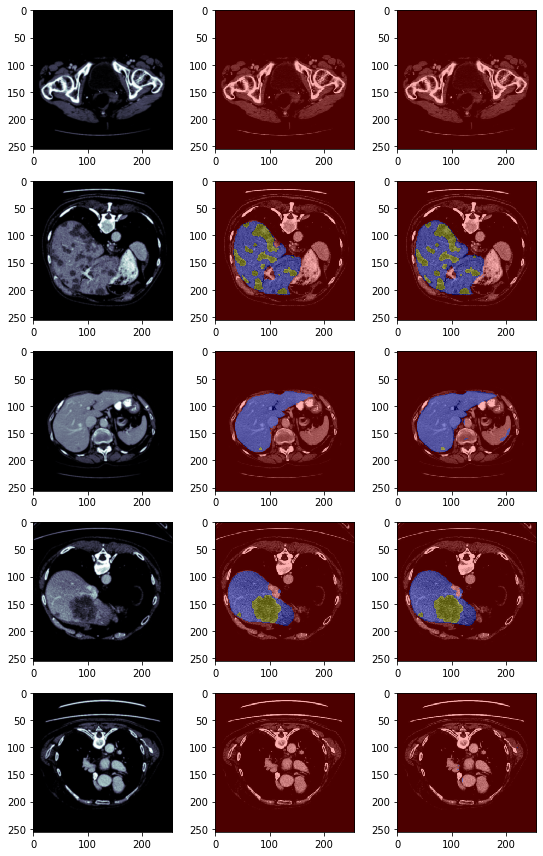

In [ ]:
from skimage import io
from skimage import color

import gc
torch.cuda.empty_cache()
gc.collect()

n_samples = 5

model.eval()
with torch.no_grad():
  for batch in train_dl_test:
    x, y = batch
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model(x)

    predictions = torch.nn.functional.softmax(pred, dim=1)
    pred_labels = torch.argmax(pred, dim=1) 
    
    # print(x.shape, y.shape, pred_labels.shape)

    x = x.cpu().squeeze(1).numpy()
    y = y.cpu().squeeze(1).numpy()
    pred_labels = pred_labels.cpu().numpy()

    # print(x.shape, y.shape, pred_labels.shape)

    w = 40
    h = 8
    rows = n_samples
    columns = 3
    # fig = plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(8, 12))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    min_imgs_in_batch = min(
        train_dl_test.batch_size, 
        len(train_dl_test.dataset)
    )
    for i in range(min(n_samples, min_imgs_in_batch)):
      img = x[i]
      labels = y[i]
      prediction = pred_labels[i]
      fig.add_subplot(rows, columns, i*3+1)
      plt.imshow(img, cmap='bone')
      fig.add_subplot(rows, columns, i*3+2)
      io.imshow(color.label2rgb(labels, img))
      fig.add_subplot(rows, columns, i*3+3)
      io.imshow(color.label2rgb(prediction, img))
    plt.show()

    # plt.figure(figsize=(25,40))

    # grid_imgs = torchvision.utils.make_grid(x) 
    # np_grid_imgs = grid_imgs.numpy()
    # imgs_for_plot = np.transpose(np_grid_imgs, (1,2,0))

    # grid_labels = torchvision.utils.make_grid(x) 
    # np_grid_labels = grid_labels.numpy()
    # labels_for_plot = np.transpose(np_grid_labels, (1,2,0))
    # print(labels_for_plot.shape, imgs_for_plot.shape)
    # print(labels_for_plot.shape == imgs_for_plot.shape)
    # plt.imshow(
    #     color.label2rgb(labels_for_plot, imgs_for_plot)
    #     )
    break
    # y = y[0][0].cpu().numpy()
    # pred_labels = pred_labels[0].detach().cpu().numpy()

    # x = x[0][0].cpu().numpy()
    # w = 10
    # h = 10
    # fig = plt.figure(figsize=(8, 8))
    # columns = 3
    # rows = 1
    # fig.add_subplot(rows, columns, 1)
    # plt.imshow(x, cmap='bone')
    # fig.add_subplot(rows, columns, 2)
    # io.imshow(color.label2rgb(y, x))
    # fig.add_subplot(rows, columns, 3)
    # io.imshow(color.label2rgb(pred_labels, x))
    # plt.show()

In [ ]:
from skimage import io
from skimage import color

import gc

def show_results(n_samples, dl):
  torch.cuda.empty_cache()
  gc.collect()

  # n_samples = 5

  model.eval()
  with torch.no_grad():
    for batch in dl:
      x, y = batch
      x, y = x.to(DEVICE), y.to(DEVICE)
      pred = model(x)

      predictions = torch.nn.functional.softmax(pred, dim=1)
      pred_labels = torch.argmax(pred, dim=1) 
      
      # print(x.shape, y.shape, pred_labels.shape)

      x = x.cpu().squeeze(1).numpy()
      y = y.cpu().squeeze(1).numpy()
      pred_labels = pred_labels.cpu().numpy()

      # print(x.shape, y.shape, pred_labels.shape)

      w = 40
      h = 8
      rows = n_samples
      columns = 3
      # fig = plt.figure(figsize=(8, 8))
      fig = plt.figure(figsize=(8, 12))
      plt.subplots_adjust(wspace=0.01, hspace=0.01)
      min_imgs_in_batch = min(
          dl.batch_size, 
          len(dl.dataset)
      )
      for i in range(min(n_samples, min_imgs_in_batch)):
        img = x[i]
        labels = y[i]
        prediction = pred_labels[i]
        fig.add_subplot(rows, columns, i*3+1)
        plt.imshow(img, cmap='bone')
        fig.add_subplot(rows, columns, i*3+2)
        io.imshow(color.label2rgb(labels, img))
        fig.add_subplot(rows, columns, i*3+3)
        io.imshow(color.label2rgb(prediction, img))
      plt.show()
      break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


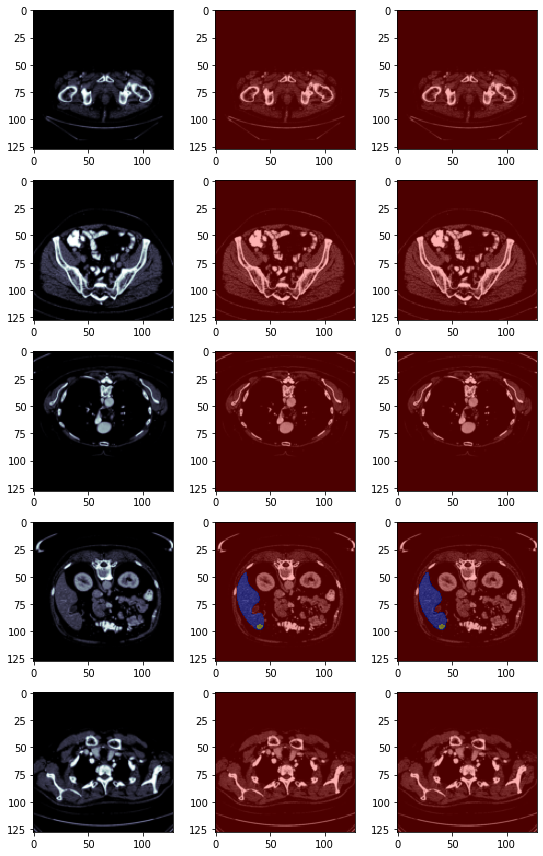

In [ ]:
show_results(5, train_dl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


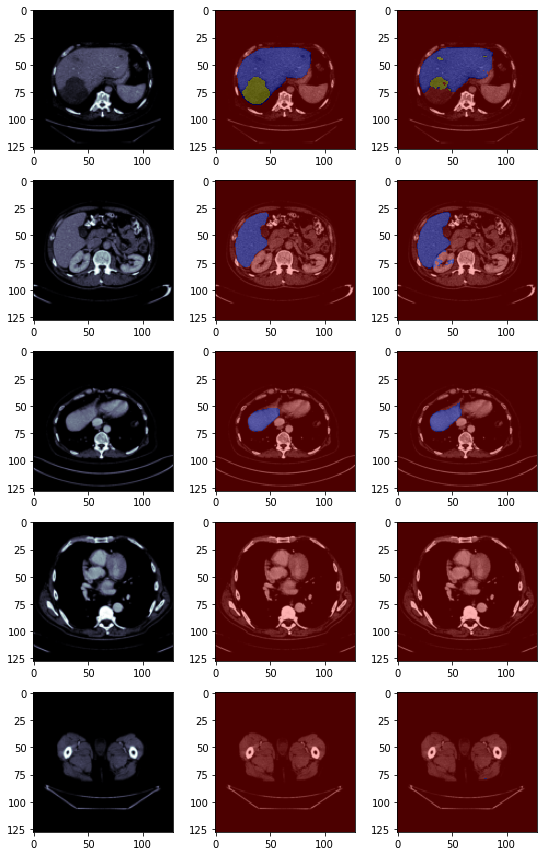

In [ ]:
show_results(5, val_dl)

# Debug

In [ ]:
256 * 256

65536

In [ ]:
base_model_1 = torchvision.models.resnet18(pretrained=True)
base_model_2 = torchvision.models.resnet34(pretrained=True)
bl_1 = [x for x in base_model_1.children()]
bl_2 = [x for x in base_model_2.children()]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weigh

In [ ]:
for x,y in zip(bl_1, bl_2):
  print('X STARTS')
  print(x)
  print('Y STARTS')
  print(y)
  print('-' * 10)

X STARTS
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Y STARTS
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
----------
X STARTS
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Y STARTS
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
----------
X STARTS
ReLU(inplace=True)
Y STARTS
ReLU(inplace=True)
----------
X STARTS
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Y STARTS
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
----------
X STARTS
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, 

In [ ]:
len(bl_1), len(bl_2)

(10, 10)

In [ ]:
nn.Conv2d()

In [ ]:
bl_1[:3], bl_2[:3]

([Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True)],
 [Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
  ReLU(inplace=True)])

In [ ]:
bl_1[3:5], bl_2[3:5]

([MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )],
 [MaxPool2d(kernel_size=3, stride=2, p

In [ ]:
|bl_1[5], bl_2[5]

(Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchN

In [ ]:
bl_1[6], bl_2[6]

(Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
bl_1[7], bl_2[7]

(Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
bl[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
bl[1]

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
bl[2]

ReLU(inplace=True)

In [ ]:
bl[3]

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [ ]:
bl[4]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
bl[5]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [ ]:
bl[6]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1